# 03 - Exploratory Data Analysis

This notebook performs EDA on the cleaned air quality data and determines dashboard aggregations.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Data directory
PROJECT_ROOT = Path().resolve().parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

print(f"Processed data: {DATA_PROCESSED}")


Processed data: /Users/shohruz/Air-Quality-Analysis/data/processed


In [4]:
# Load cleaned data
parquet_path = DATA_PROCESSED / "measurements.parquet"
df = pd.read_parquet(parquet_path, engine='pyarrow')

print(f"Loaded {len(df)} records")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nPollutants: {df['pollutant'].unique()}")
print(f"\nBoroughs: {df['borough'].unique()}")
print(f"\nStations: {df['station_id'].nunique()}")

df.head()


Loaded 18862 records
Date range: 2004-12-31 19:00:00-05:00 to 2023-05-31 20:00:00-04:00

Pollutants: ['Annual vehicle miles traveled'
 'Asthma emergency department visits due to PM2.5'
 'Respiratory hospitalizations due to PM2.5 (age 20+)'
 'Asthma hospitalizations due to Ozone'
 'Outdoor Air Toxics - Formaldehyde'
 'Asthma emergency departments visits due to Ozone'
 'Annual vehicle miles traveled (cars)' 'Outdoor Air Toxics - Benzene'
 'Annual vehicle miles traveled (trucks)' 'Deaths due to PM2.5'
 'Cardiac and respiratory deaths due to Ozone'
 'Cardiovascular hospitalizations due to PM2.5 (age 40+)' 'NO2' 'PM2.5'
 'O3' 'Boiler Emissions- Total SO2 Emissions'
 'Boiler Emissions- Total PM2.5 Emissions'
 'Boiler Emissions- Total NOx Emissions']

Boroughs: ['Unknown' 'Queens' 'Brooklyn' 'Staten Island' 'Manhattan' 'Bronx']

Stations: 72


,timestamp,date,hour,weekday,year,month,season,time_period,pollutant,value,unit,station_id,station_name,geo_type,lat,lon,borough,is_outlier
0,2004-12-31 19:00:00-05:00,2004-12-31,None,None,2004,12,2005,2005,Annual vehicle miles traveled,31.851360,per square mile,313,Coney Island (CD13),CD,None,None,Unknown,False
1,2004-12-31 19:00:00-05:00,2004-12-31,None,None,2004,12,2005-2007,2005-2007,Asthma emergency department visits due to PM2.5,19.100000,"per 100,000 adults",405,Ridgewood - Forest Hills,UHF42,None,None,Unknown,False
2,2004-12-31 19:00:00-05:00,2004-12-31,None,None,2004,12,2005,2005,Annual vehicle miles traveled,61.967759,per square mile,406,Fresh Meadows,UHF42,None,None,Unknown,False
3,2004-12-31 19:00:00-05:00,2004-12-31,None,None,2004,12,2005-2007,2005-2007,Asthma emergency department visits due to PM2.5,30.600000,"per 100,000 adults",407,Southwest Queens,UHF42,None,None,Queens,False
4,2004-12-31 19:00:00-05:00,2004-12-31,None,None,2004,12,2005-2007,2005-2007,Respiratory hospitalizations due to PM2.5 (age...,18.300000,"per 100,000 adults",405,Ridgewood - Forest Hills,UHF42,None,None,Unknown,False


## 1. Time Series Analysis


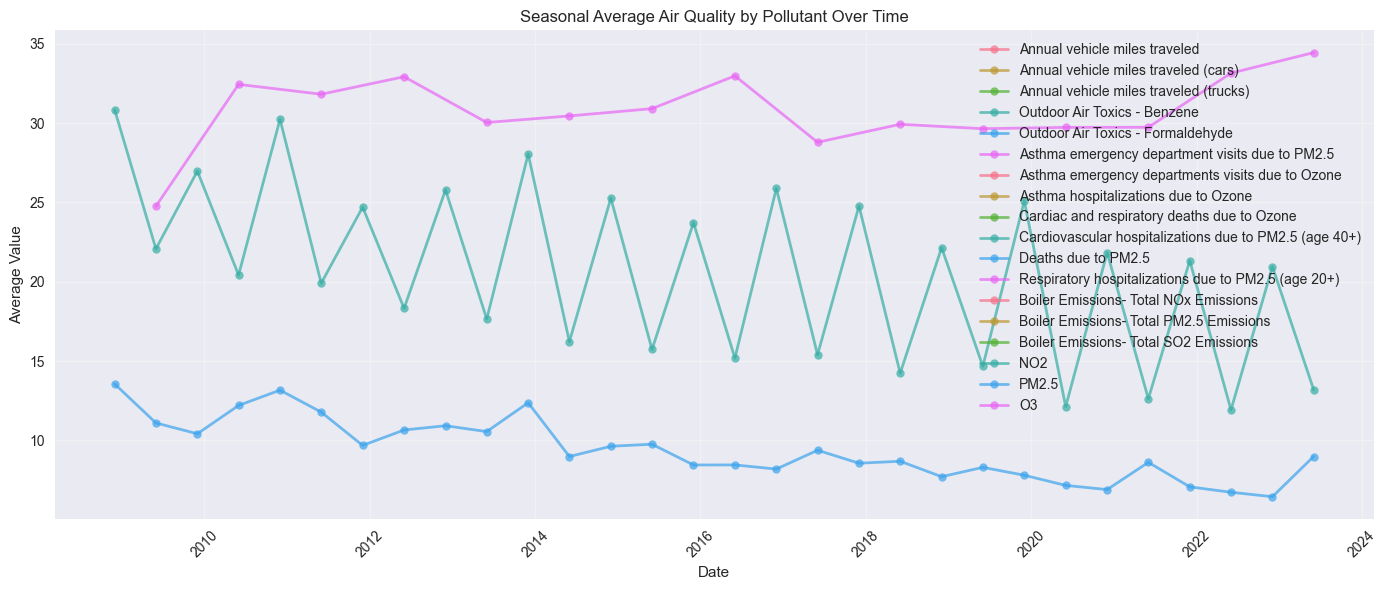

In [5]:
# Time series by season (since data is seasonal aggregates)
df['date'] = pd.to_datetime(df['date'])
df['season_year'] = df['season'] + ' ' + df['year'].astype(str)

# Average by season and pollutant
seasonal_avg = df.groupby(['season_year', 'pollutant'])['value'].mean().reset_index()
# Create approximate date for plotting
season_to_month = {'Summer': '06', 'Winter': '12', 'Spring': '03', 'Fall': '09'}
seasonal_avg['plot_date'] = pd.to_datetime(
    seasonal_avg['season_year'].str.split().str[1] + '-' + 
    seasonal_avg['season_year'].str.split().str[0].map(season_to_month) + '-01',
    format='%Y-%m-%d', errors='coerce'
)

fig, ax = plt.subplots(figsize=(14, 6))
for pollutant in seasonal_avg['pollutant'].unique():
    data = seasonal_avg[seasonal_avg['pollutant'] == pollutant].sort_values('plot_date')
    ax.plot(data['plot_date'], data['value'], marker='o', label=pollutant, alpha=0.7, linewidth=2, markersize=6)

ax.set_xlabel('Date')
ax.set_ylabel('Average Value')
ax.set_title('Seasonal Average Air Quality by Pollutant Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2. Diurnal Cycle (Hourly Patterns)


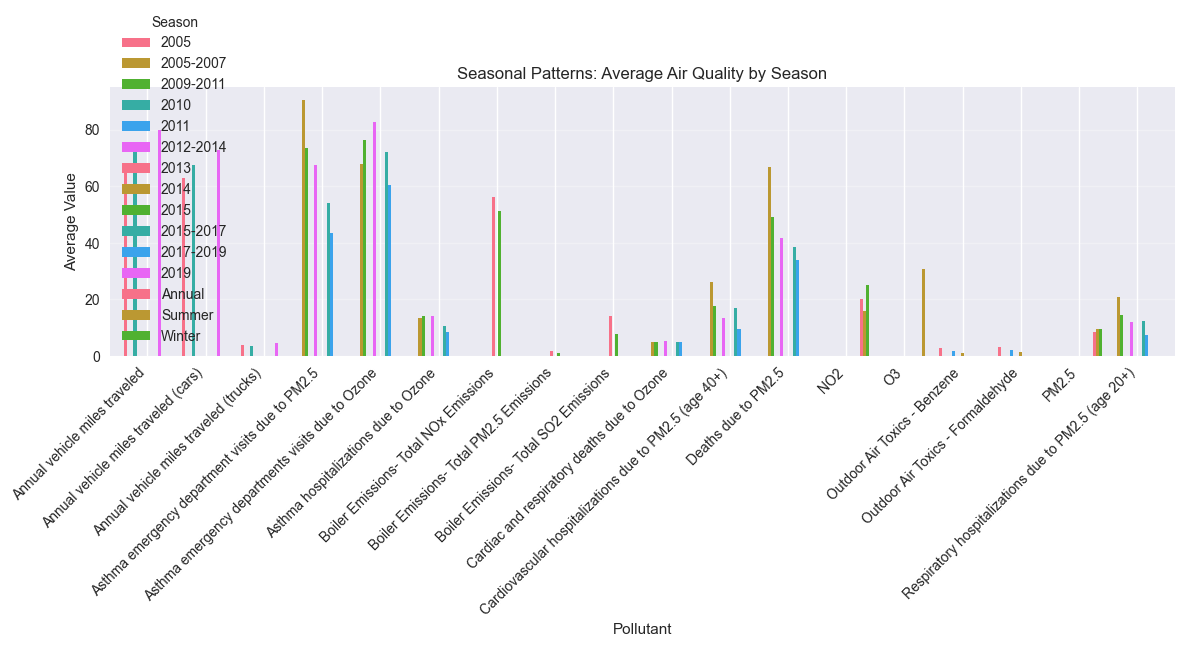

Note: This dataset contains seasonal aggregates, not hourly measurements.


In [6]:
# Note: This dataset contains seasonal aggregates, not hourly data
# Instead, show seasonal patterns
seasonal_pattern = df.groupby(['season', 'pollutant'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
pivot = seasonal_pattern.pivot(index='pollutant', columns='season', values='value')
pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Pollutant')
ax.set_ylabel('Average Value')
ax.set_title('Seasonal Patterns: Average Air Quality by Season')
ax.legend(title='Season')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Note: This dataset contains seasonal aggregates, not hourly measurements.")


## 3. Weekday vs Weekend Differences


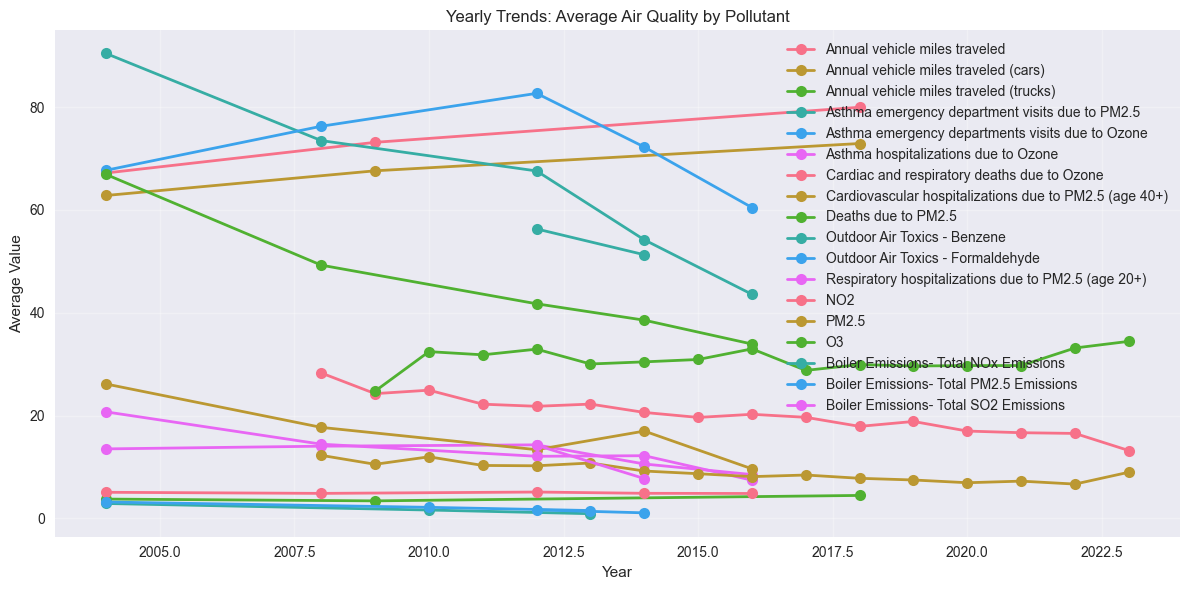

Note: This dataset contains seasonal aggregates, so weekday/weekend comparison is not applicable.


In [7]:
# Note: This dataset doesn't have weekday/weekend distinction (seasonal aggregates)
# Instead, compare by year to show trends
yearly_avg = df.groupby(['year', 'pollutant'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
for pollutant in yearly_avg['pollutant'].unique():
    data = yearly_avg[yearly_avg['pollutant'] == pollutant]
    ax.plot(data['year'], data['value'], marker='o', label=pollutant, linewidth=2, markersize=8)

ax.set_xlabel('Year')
ax.set_ylabel('Average Value')
ax.set_title('Yearly Trends: Average Air Quality by Pollutant')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Note: This dataset contains seasonal aggregates, so weekday/weekend comparison is not applicable.")


## 4. Top Stations by Measurement Count


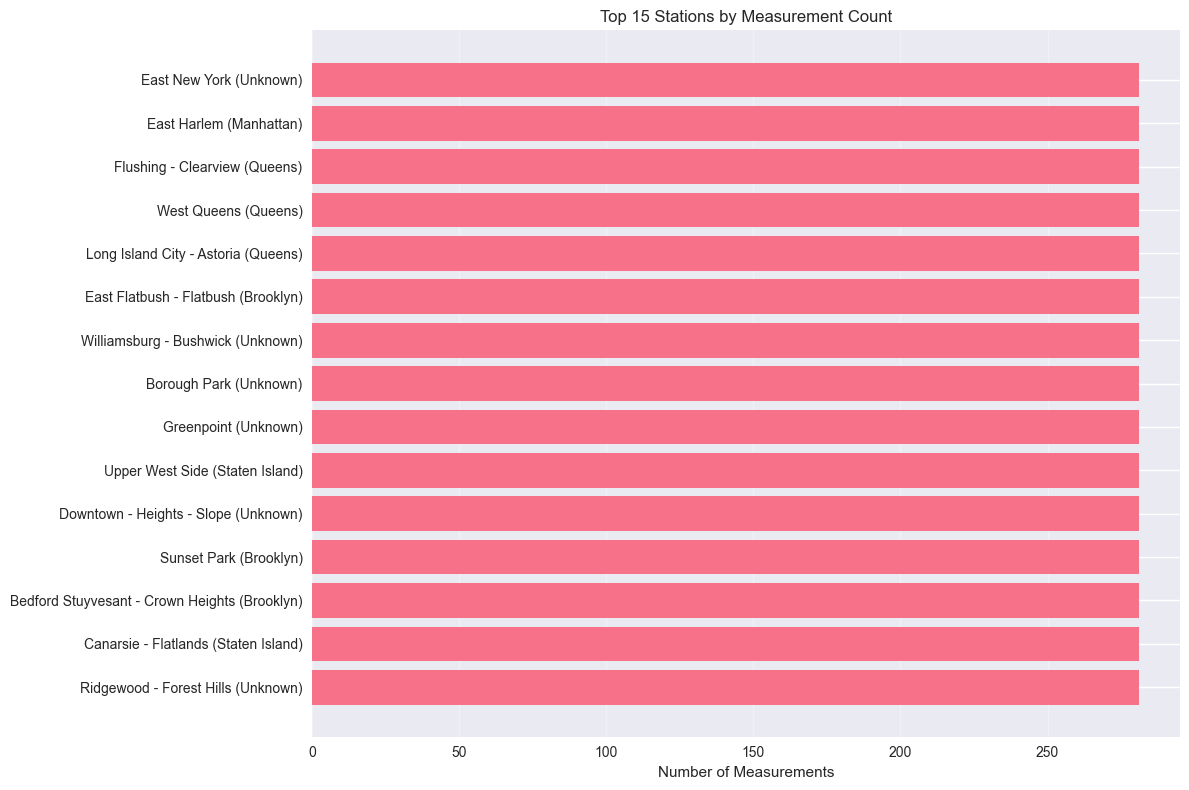

Top 10 stations:
                          station_name        borough  count
88            Ridgewood - Forest Hills        Unknown    281
37                Canarsie - Flatlands  Staten Island    281
27  Bedford Stuyvesant - Crown Heights       Brooklyn    281
32                         Sunset Park       Brooklyn    281
25          Downtown - Heights - Slope        Unknown    281
54                     Upper West Side  Staten Island    281
23                          Greenpoint        Unknown    281
34                        Borough Park        Unknown    281
44             Williamsburg - Bushwick        Unknown    281
35            East Flatbush - Flatbush       Brooklyn    281


In [8]:
# Top stations by number of measurements
station_counts = df.groupby(['station_id', 'station_name', 'borough']).size().reset_index(name='count')
station_counts = station_counts.sort_values('count', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(station_counts)), station_counts['count'])
ax.set_yticks(range(len(station_counts)))
ax.set_yticklabels([f"{row['station_name']} ({row['borough']})" 
                     for _, row in station_counts.iterrows()])
ax.set_xlabel('Number of Measurements')
ax.set_title('Top 15 Stations by Measurement Count')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Top 10 stations:")
print(station_counts.head(10)[['station_name', 'borough', 'count']])


## 5. Distribution by Borough


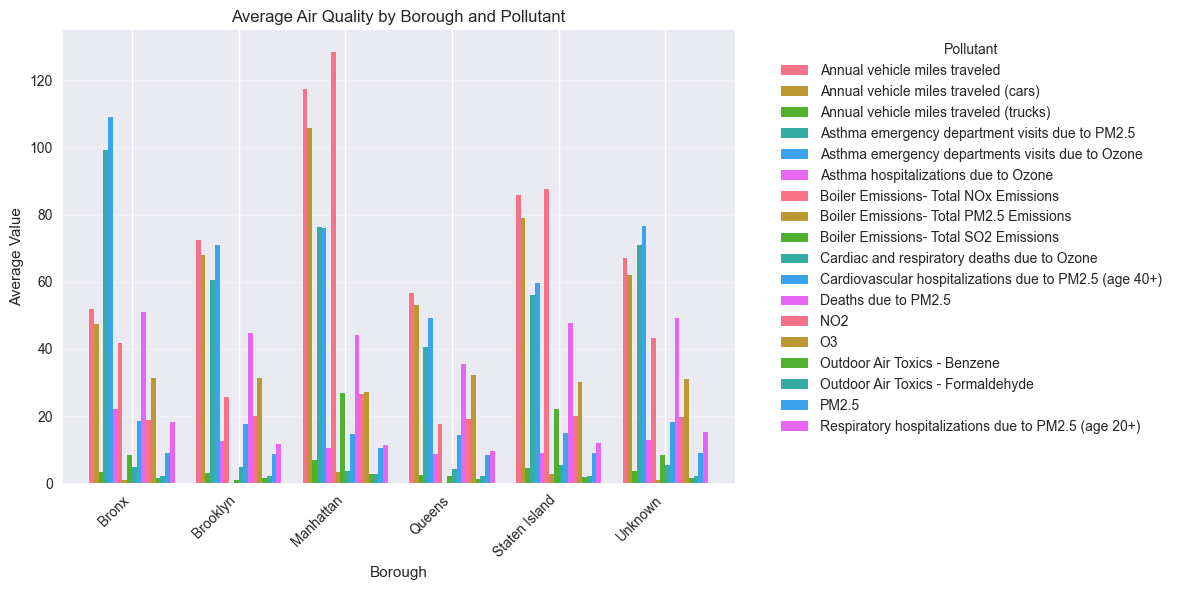

In [9]:
# Average values by borough and pollutant
borough_avg = df.groupby(['borough', 'pollutant'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
pivot = borough_avg.pivot(index='borough', columns='pollutant', values='value')
pivot.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Borough')
ax.set_ylabel('Average Value')
ax.set_title('Average Air Quality by Borough and Pollutant')
ax.legend(title='Pollutant', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 6. Value Distributions (Histograms)


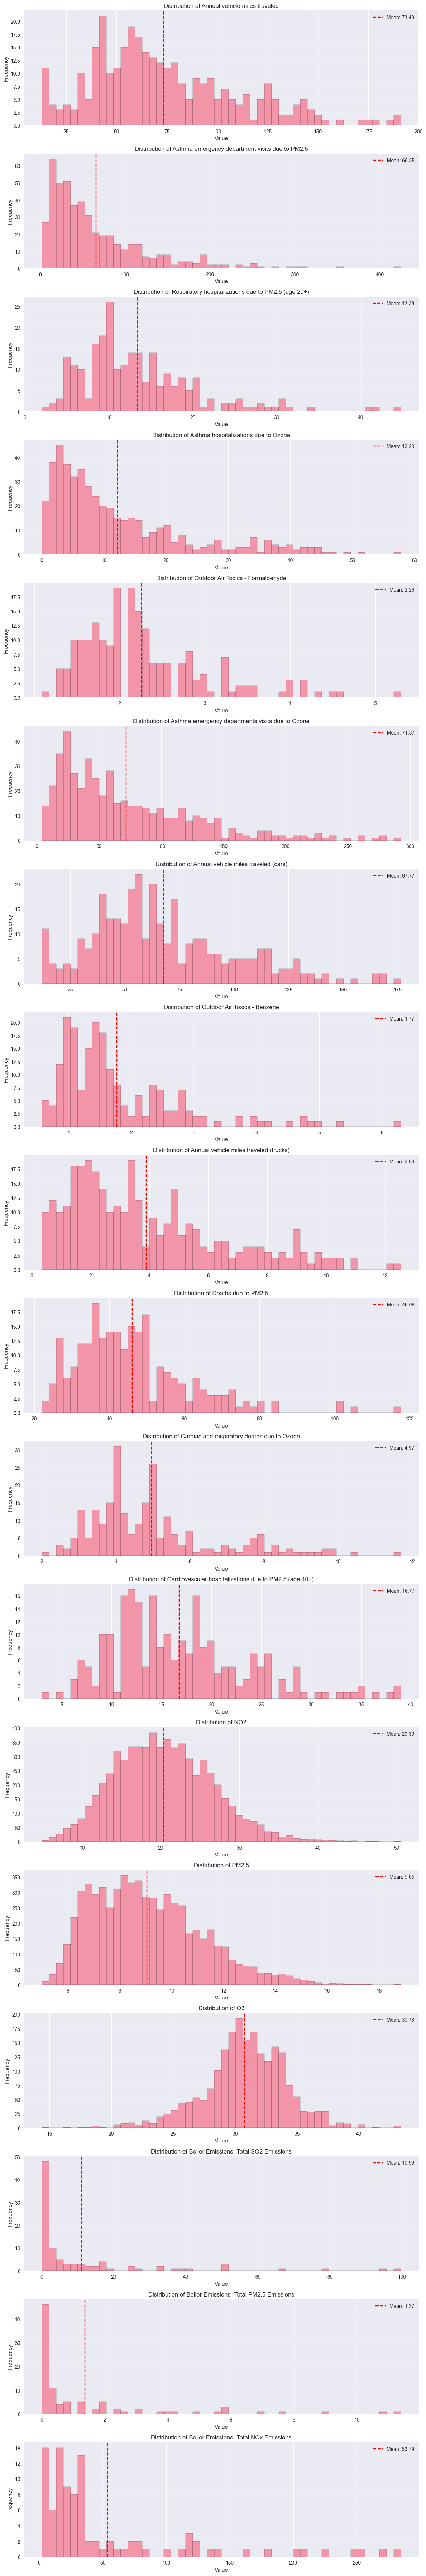

In [10]:
# Histograms by pollutant
pollutants = df['pollutant'].unique()
n_pollutants = len(pollutants)
fig, axes = plt.subplots(n_pollutants, 1, figsize=(12, 4*n_pollutants))

if n_pollutants == 1:
    axes = [axes]

for ax, pollutant in zip(axes, pollutants):
    data = df[df['pollutant'] == pollutant]['value']
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {pollutant}')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
    ax.legend()

plt.tight_layout()
plt.show()


## 7. Summary Statistics


In [11]:
# Summary statistics by pollutant
summary = df.groupby('pollutant')['value'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
print("Summary Statistics by Pollutant:")
print(summary)


Summary Statistics by Pollutant:
                                                    count   mean    std  \
pollutant                                                                 
Annual vehicle miles traveled                         321  73.43  36.48   
Annual vehicle miles traveled (cars)                  321  67.77  33.01   
Annual vehicle miles traveled (trucks)                321   3.89   2.65   
Asthma emergency department visits due to PM2.5       480  65.85  60.20   
Asthma emergency departments visits due to Ozone      480  71.87  56.06   
Asthma hospitalizations due to Ozone                  480  12.20  11.29   
Boiler Emissions- Total NOx Emissions                  96  53.79  66.08   
Boiler Emissions- Total PM2.5 Emissions                96   1.37   2.37   
Boiler Emissions- Total SO2 Emissions                  96  10.99  19.95   
Cardiac and respiratory deaths due to Ozone           240   4.97   1.73   
Cardiovascular hospitalizations due to PM2.5 (a...    240  16.77   

## Dashboard Fields - Aggregations to Support

Based on the EDA, here are the recommended aggregations and filters for the dashboard:


### Filters:
1. **Date Range**: Start date and end date picker
2. **Pollutant**: Multi-select (PM2.5, PM10, O3, NO2, etc.)
3. **Borough**: Multi-select (Manhattan, Brooklyn, Queens, Bronx, Staten Island)
4. **Station**: Multi-select (filter by station_id or station_name)
5. **Day Type**: Weekday vs Weekend toggle

### Aggregations:
1. **Temporal Aggregations**:
   - Hourly averages (for diurnal cycle)
   - Daily averages (for time series trends)
   - Weekly averages
   - Monthly averages
   - Yearly averages

2. **Spatial Aggregations**:
   - By borough (average across stations in borough)
   - By station (individual station trends)
   - Cross-borough comparisons

3. **Statistical Aggregations**:
   - Mean, median, min, max
   - Percentiles (25th, 75th, 95th)
   - Standard deviation

### Visualizations:
1. **Time Series**: Line chart showing trends over time (daily/weekly/monthly)
2. **Diurnal Cycle**: Hourly averages by pollutant
3. **Borough Comparison**: Bar chart or heatmap comparing boroughs
4. **Station Map**: Map showing station locations (if lat/lon available)
5. **Distribution**: Histogram or box plot of values
6. **Weekday vs Weekend**: Side-by-side comparison

### Key Metrics to Display:
- Current average by pollutant and borough
- Peak hours for each pollutant
- Worst-performing stations/boroughs
- Trend direction (improving/worsening)
